In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data reading

In [2]:
#raw_data = pd.read_csv("raw_data.csv")
raw_data = pd.read_csv("smooth_raw_data.csv")


In [3]:
raw_data.head(8)

,Sales,Item
0,-0.048506,IT001
1,0.019767,IT001
2,0.040116,IT001
3,-0.067794,IT001
4,0.147107,IT001
5,0.107668,IT001
6,0.053774,IT001
7,0.233600,IT001


In [4]:
raw_data.tail(8)

,Sales,Item
1492,-1.477001,IT001
1493,-1.608354,IT001
1494,-1.530242,IT001
1495,-1.773212,IT001
1496,-1.610350,IT001
1497,-1.578478,IT001
1498,-1.712295,IT001
1499,-1.751332,IT001


### Train test split

Since the data is a sequence we cannot chose them randomly but to choose a cutoff of train data (80% first points).

In [5]:
n_points = 6 #lookback 
# train test split
split = int(0.8 * len(raw_data))
train = raw_data["Sales"].values[:split+n_points] #little overlaping, extra n_points, index split show first column, we need n_points more
test = raw_data["Sales"].values[split:]

## Building dataset for input to deep learinig

*n_points* (N) is lookback number. it shows how many previous time  points in sequence is taken to the sample (row) in training/testing data. last column  is a label. 

In [6]:
def make_input(data,n_points):
    '''
    Function generating the np.array with train/test points as an input for ML models
    '''
    n_rows = len(data)
    result = np.empty((n_rows - n_points,n_points))
    for i in range(n_rows-n_points):
                result[i,:] = data[i : i+n_points]
    return result

In [7]:
data = raw_data["Sales"].values
X_train  = make_input(train,n_points)
X_test = make_input(test,n_points)
y_train = raw_data["Sales"].values[n_points:split+n_points]
y_test = raw_data["Sales"].values[split+n_points:]

In [8]:
#data visualisation
column_name = [f"T_(N-{i})" for i in range(n_points,0,-1)]
Xtrn = pd.DataFrame(X_train,columns = column_name)
Xtrn["label T_N"] = y_train
Xtrn

,T_(N-6),T_(N-5),T_(N-4),T_(N-3),T_(N-2),T_(N-1),label T_N
0,-0.048506,0.019767,0.040116,-0.067794,0.147107,0.107668,0.053774
1,0.019767,0.040116,-0.067794,0.147107,0.107668,0.053774,0.233600
2,0.040116,-0.067794,0.147107,0.107668,0.053774,0.233600,0.122611
3,-0.067794,0.147107,0.107668,0.053774,0.233600,0.122611,0.147552
4,0.147107,0.107668,0.053774,0.233600,0.122611,0.147552,0.076243
...,...,...,...,...,...,...,...
1195,-1.035467,-1.288729,-1.179826,-1.061486,-1.235705,-1.312734,-1.082842
1196,-1.288729,-1.179826,-1.061486,-1.235705,-1.312734,-1.082842,-1.006755
1197,-1.179826,-1.061486,-1.235705,-1.312734,-1.082842,-1.006755,-1.054599
1198,-1.061486,-1.235705,-1.312734,-1.082842,-1.006755,-1.054599,-1.135403


In [9]:
Xtst = pd.DataFrame(X_test,columns = column_name)
Xtst["label T_N"] = y_test
Xtst

,T_(N-6),T_(N-5),T_(N-4),T_(N-3),T_(N-2),T_(N-1),label T_N
0,-1.312734,-1.082842,-1.006755,-1.054599,-1.135403,-1.001528,-1.123523
1,-1.082842,-1.006755,-1.054599,-1.135403,-1.001528,-1.123523,-1.232927
2,-1.006755,-1.054599,-1.135403,-1.001528,-1.123523,-1.232927,-1.011258
3,-1.054599,-1.135403,-1.001528,-1.123523,-1.232927,-1.011258,-1.194356
4,-1.135403,-1.001528,-1.123523,-1.232927,-1.011258,-1.194356,-0.873230
...,...,...,...,...,...,...,...
289,-1.608900,-1.581273,-1.670592,-1.477001,-1.608354,-1.530242,-1.773212
290,-1.581273,-1.670592,-1.477001,-1.608354,-1.530242,-1.773212,-1.610350
291,-1.670592,-1.477001,-1.608354,-1.530242,-1.773212,-1.610350,-1.578478
292,-1.477001,-1.608354,-1.530242,-1.773212,-1.610350,-1.578478,-1.712295


### Scaling Data

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Building LSTM net

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,LSTM

In [13]:
model = Sequential()
#model.add(LSTM(4, input_shape=(1, n_points)))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape( (X_test.shape[0], 1, X_test.shape[1]))

In [15]:
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
1200/1200 - 1s - loss: 0.1639
Epoch 2/20
1200/1200 - 1s - loss: 0.0320
Epoch 3/20
1200/1200 - 1s - loss: 0.0260
Epoch 4/20
1200/1200 - 1s - loss: 0.0236
Epoch 5/20
1200/1200 - 1s - loss: 0.0234
Epoch 6/20
1200/1200 - 1s - loss: 0.0227
Epoch 7/20
1200/1200 - 1s - loss: 0.0227
Epoch 8/20
1200/1200 - 1s - loss: 0.0224
Epoch 9/20
1200/1200 - 1s - loss: 0.0225
Epoch 10/20
1200/1200 - 1s - loss: 0.0221
Epoch 11/20
1200/1200 - 1s - loss: 0.0219
Epoch 12/20
1200/1200 - 1s - loss: 0.0220
Epoch 13/20
1200/1200 - 1s - loss: 0.0219
Epoch 14/20
1200/1200 - 1s - loss: 0.0223
Epoch 15/20
1200/1200 - 1s - loss: 0.0223
Epoch 16/20
1200/1200 - 1s - loss: 0.0223
Epoch 17/20
1200/1200 - 1s - loss: 0.0223
Epoch 18/20
1200/1200 - 1s - loss: 0.0222
Epoch 19/20
1200/1200 - 1s - loss: 0.0220
Epoch 20/20
1200/1200 - 1s - loss: 0.0219


Loss function plot

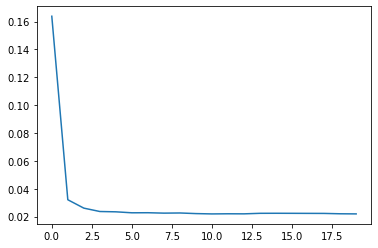

In [16]:
plt.plot(model.history.history["loss"])

## Model Evaluation

In [17]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)

In [18]:
training_score

0.021777242422103882

In [19]:
test_score

0.025251422077417374

In [20]:
test_predictions = model.predict(X_test)

In [21]:
summary = pd.DataFrame({"test" : y_test.reshape(-1,),
                        "prediction":test_predictions.reshape(-1,)})

In [22]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
#TODO find other metrics

In [23]:
mean_absolute_error(summary['test'],summary['prediction'])

0.13183743188086652

In [24]:
mean_squared_error(summary['test'],summary['prediction'])

0.025251424262696977

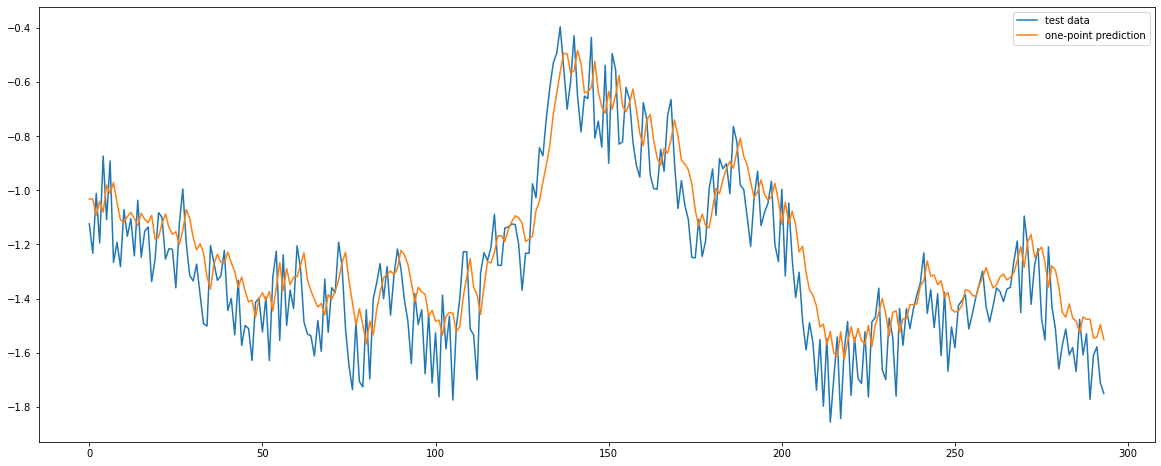

In [25]:
plt.figure(figsize=(20,8))
plt.plot(summary["test"])
plt.plot(summary["prediction"])
plt.legend(["test data", "one-point prediction"])

Comparison of test data, prediction and relative error

REMARK: I used only one point ahead prediction

In [26]:
summary['rel_error'] = np.abs((summary['test']- summary['prediction'])/summary['test'])

In [27]:
summary

,test,prediction,rel_error
0,-1.123523,-1.032343,0.081155
1,-1.232927,-1.031713,0.163200
2,-1.011258,-1.091677,0.079524
3,-1.194356,-1.040159,0.129105
4,-0.873230,-1.080745,0.237640
...,...,...,...
289,-1.773212,-1.476051,0.167584
290,-1.610350,-1.545828,0.040067
291,-1.578478,-1.542953,0.022506
292,-1.712295,-1.496102,0.126259


In [28]:
round(summary['rel_error'].mean(),2)

0.11

In [29]:
round(summary['rel_error'].std(),2)

0.08

#### Saving model to disc

In [30]:
from tensorflow.keras.models import load_model

In [31]:
model.save('lstm.h5')  # creates a HDF5 file 'my_model.h5'

In [32]:
later_model = load_model('lstm.h5')

## Random Forrest

For comparison, the same thing with Random Forest estimator

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rf = RandomForestRegressor(n_estimators=200)

In [35]:
rf.fit(X_train.reshape(-1,n_points),y_train)

RandomForestRegressor(n_estimators=200)

In [36]:
rf_prediction = rf.predict(X_test.reshape(-1,n_points))

In [37]:
rf_results = pd.DataFrame({'prediction': rf_prediction, 'test' : y_test})

In [38]:
rf_results ['rel_error'] = np.abs((rf_results['test']- rf_results['prediction'])/rf_results ['test'])
rf_results

,prediction,test,rel_error
0,-1.075883,-1.123523,0.042403
1,-1.079928,-1.232927,0.124095
2,-1.250170,-1.011258,0.236253
3,-1.129478,-1.194356,0.054321
4,-1.117400,-0.873230,0.279616
...,...,...,...
289,-1.355486,-1.773212,0.235576
290,-1.357063,-1.610350,0.157287
291,-1.356869,-1.578478,0.140394
292,-1.356244,-1.712295,0.207938


In [39]:
round(rf_results['rel_error'].mean(),2)

0.12

In [40]:
round(rf_results['rel_error'].std(),2)

0.1

## Questions:


1. What is estimated frequency of real transaction data
2. Possible sources of sample data
3. Build the model with linked transaction data with historical stock price 

## Planned TODO

1. Markov models
2. MLP
